In [1]:
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

from aerobot.io import load_training_data, load_validation_data
from aerobot.utls import process_data, count_aa_kmers, download_genomes_from_assembly
from aerobot.models import LogisticClassifier

from collections import defaultdict
from matplotlib import pyplot as plt
from os import path
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import viz
colors = viz.plotting_style()
default_pal = [
    colors['purple'], colors['dark_green'], colors['light_blue'], 
    colors['red'], colors['dark_green'], colors['dark_brown'],
    colors['yellow'], colors['light_red'], colors['light_blue'], 
    colors['light_green'], colors['light_purple']]

plt.style.use('style.mpl')

In [2]:
# Load binary and ternary results
ternary_results = pd.read_pickle('../scripts/logisticReg_l2_c100_1e4iter_models.ternary.pkl')
binary_results = pd.read_pickle('../scripts/logisticReg_l2_c100_1e4iter_models.binary.pkl')

ternary_results = ternary_results[ternary_results.converged]
binary_results = binary_results[binary_results.converged]

In [3]:
# Mark the annotation-free models
annotation_full = ['KO', 
                   'embedding.geneset.oxygen',
                   'metadata.oxygen_genes',
                   'metadata.pct_oxygen_genes']

binary_results['annotation_free'] = True
mask = binary_results['feature_set'].isin(annotation_full)
binary_results.loc[mask, 'annotation_free'] = False

ternary_results['annotation_free'] = True
mask = ternary_results['feature_set'].isin(annotation_full)
ternary_results.loc[mask, 'annotation_free'] = False

ternary_results['feature_set,annotation_free'.split(',')]


,feature_set,annotation_free
0,KO,False
1,embedding.genome,True
2,embedding.geneset.oxygen,False
3,metadata.number_of_genes,True
4,metadata.oxygen_genes,False
5,metadata.pct_oxygen_genes,False
6,aa_1mer,True
7,aa_2mer,True
8,aa_3mer,True
9,chemical,True


In [4]:
# Order ternary results by validation accuracy while separating annotation-free models
ternary_results = ternary_results.sort_values('annotation_free,test_balanced_accuracy'.split(','), ascending=True)
# Binary results in the same order 
binary_results = binary_results.loc[ternary_results.index]

ternary_results['feature_set,test_balanced_accuracy,annotation_free'.split(',')].head(10)

,feature_set,test_balanced_accuracy,annotation_free
4,metadata.oxygen_genes,0.606245,False
5,metadata.pct_oxygen_genes,0.618307,False
2,embedding.geneset.oxygen,0.728100,False
0,KO,0.816724,False
3,metadata.number_of_genes,0.448813,True
10,nt_1mer,0.462957,True
15,cds_1mer,0.467925,True
11,nt_2mer,0.541913,True
16,cds_2mer,0.560147,True
9,chemical,0.581282,True


In [5]:
binary_results['feature_set,test_balanced_accuracy,annotation_free'.split(',')]

,feature_set,test_balanced_accuracy,annotation_free
4,metadata.oxygen_genes,0.885261,False
5,metadata.pct_oxygen_genes,0.901134,False
2,embedding.geneset.oxygen,0.895375,False
0,KO,0.941723,False
3,metadata.number_of_genes,0.633107,True
10,nt_1mer,0.618367,True
15,cds_1mer,0.654065,True
11,nt_2mer,0.762585,True
16,cds_2mer,0.771960,True
9,chemical,0.847915,True


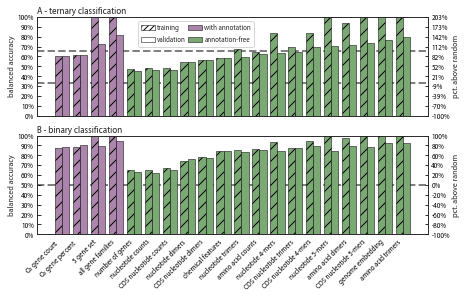

In [6]:
# Two-row figure with ternary and binary results --- two bars
# per model, one for training accuracy and one for validation accuracy
# TODO: color by annotation-free or not
fig, axs = plt.subplots(2, 1, figsize=(7, 4), sharex=True)

color_map = {True: colors['green'], False: colors['purple']}
my_colors = [color_map[v] for v in ternary_results.annotation_free]

# Ternary results
ax = axs[0]
plt.sca(ax)
ax.set_ylabel('balanced accuracy')
ax.set_ylim(0, 1)
ytick_pos = np.arange(0, 1.1, 0.1)
ax.set_yticks(ytick_pos)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.bar(np.arange(0, len(ternary_results), 1) - 0.2, ternary_results.balanced_accuracy,
       width=0.4, label='training', color=my_colors, edgecolor='k', linewidth=0.5, hatch='//')
ax.bar(np.arange(0, len(ternary_results), 1) + 0.2, ternary_results.test_balanced_accuracy,
       width=0.4, label='validation', color=my_colors, edgecolor='k', linewidth=0.5)
plt.axhline(0.33, color='grey', linestyle='--', linewidth=2, zorder=-10)
plt.axhline(0.66, color='grey', linestyle='--', linewidth=2, zorder=-10)
plt.title('A - ternary classification', loc='left')

# custom legend -- colors for annotation free/full and hatches for training/validation
handles = [plt.Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='k', linewidth=0.5, hatch='////'),
           plt.Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='k', linewidth=0.5, hatch=''),
           plt.Rectangle((0, 0), 1, 1, facecolor=color_map[False], edgecolor='k', linewidth=0.5),
           plt.Rectangle((0, 0), 1, 1, facecolor=color_map[True], edgecolor='k', linewidth=0.5),
           ]
labels = ['training', 'validation', 'with annotation', 'annotation-free']

# two-column legend with absolute position
plt.legend(handles, labels, ncol=2, fontsize=7, columnspacing=0.3, handletextpad=0.3, loc='upper left',
           bbox_to_anchor=(0.25,0.99))

# second set of y-ticks on the right with percent over random (50% accurate)
ax2 = ax.twinx()
plt.sca(ax2)
ax2.set_ylim(0, 1)
tick_vals = np.round(100*(ytick_pos - 0.33) / 0.33, 1)
tick_vals = [f'{v:.0f}%' for v in tick_vals]
plt.yticks(ytick_pos, tick_vals)
ax2.set_ylabel('pct. above random')

# Binary results
ax = axs[1]
plt.sca(ax)
ax.set_ylabel('balanced accuracy')
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, len(binary_results), 1))
ax.set_xticklabels(binary_results.index, rotation=45, ha='right')
ax.set_yticks(ytick_pos)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.bar(np.arange(0, len(binary_results), 1) - 0.2, binary_results.balanced_accuracy, width=0.4,
       label='training', color=my_colors, edgecolor='k', linewidth=0.5, hatch='//')
ax.bar(np.arange(0, len(binary_results), 1) + 0.2, binary_results.test_balanced_accuracy, width=0.4,
       label='validation', color=my_colors, edgecolor='k', linewidth=0.5)
plt.axhline(0.5, color='grey', linestyle='--', linewidth=2, zorder=-10)
plt.title('B - binary classification', loc='left')

# second set of y-ticks on the right with percent over random (50% accurate)
ax2 = ax.twinx()
plt.sca(ax2)
ax2.set_ylim(0, 1)
tick_vals = np.round(100*(ytick_pos - 0.5) / 0.5, 1)
tick_vals = [f'{v:.0f}%' for v in tick_vals]
plt.yticks(ytick_pos, tick_vals)
ax2.set_ylabel('pct. above random')

# xlabels are the model name
xticks = ternary_results.pretty_feature_set
xpos = np.arange(0, len(ternary_results), 1)
plt.xticks(xpos, xticks, rotation=45, ha='right')
plt.savefig('../../results/updated_model_accuracy.png', bbox_inches='tight', facecolor='w', dpi=300)

plt.show()


KO
embedding.geneset.oxygen
aa_3mer
nt_5mer
chemical
aa_1mer


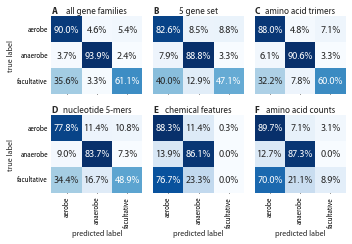

In [23]:
feature_set_names = 'KO,embedding.geneset.oxygen,aa_3mer,nt_5mer,chemical,aa_1mer'.split(',')

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(5, 3.5), sharey=True, sharex=True)
reindexed_ternary_results = ternary_results.set_index('feature_set')
flat_axs = axs.flatten()

for i, feature_set in enumerate(feature_set_names):
    print(feature_set)
    model = reindexed_ternary_results.loc[feature_set, 'model']
    classes = model.classifier.classes_
    confusion_matrix = np.zeros((len(classes), len(classes)))
    for j, true_label in enumerate(classes):
        for k, pred_label in enumerate(classes):
            key = f'{true_label},{pred_label}'
            confusion_matrix[j, k] = reindexed_ternary_results.loc[feature_set, key] 
    
    C = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    C = C.apply(lambda x: x/x.sum(), axis=1)

    plt.sca(flat_axs[i])
    plt.title(reindexed_ternary_results.loc[feature_set, 'pretty_feature_set'], loc='center')
    sns.heatmap(C, cmap='Blues', annot=True, fmt='.1%', cbar=False)

for i, (ax, label) in enumerate(zip(flat_axs, 'ABCDEF')):
    plt.sca(ax)
    plt.title(label, loc='left', fontweight='bold')
    if i > 2:
        plt.xlabel('predicted label')
    if i % 3 == 0:
        plt.ylabel('true label')

plt.tight_layout()
plt.savefig('../../results/ternary_confusion_matrices.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()


KO
embedding.geneset.oxygen
aa_3mer
nt_5mer
chemical
aa_1mer


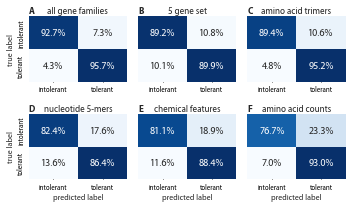

In [30]:
feature_set_names = 'KO,embedding.geneset.oxygen,aa_3mer,nt_5mer,chemical,aa_1mer'.split(',')

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(5, 3), sharey=True)
reindexed_binary_results = binary_results.set_index('feature_set')
flat_axs = axs.flatten()

for i, feature_set in enumerate(feature_set_names):
    print(feature_set)
    model = reindexed_binary_results.loc[feature_set, 'model']
    classes = model.classifier.classes_
    confusion_matrix = np.zeros((len(classes), len(classes)))
    for j, true_label in enumerate(classes):
        for k, pred_label in enumerate(classes):
            key = f'{true_label},{pred_label}'
            confusion_matrix[j, k] = reindexed_binary_results.loc[feature_set, key] 
    
    C = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    C = C.apply(lambda x: x/x.sum(), axis=1)

    plt.sca(flat_axs[i])
    plt.title(reindexed_binary_results.loc[feature_set, 'pretty_feature_set'], loc='center')
    sns.heatmap(C, cmap='Blues', annot=True, fmt='.1%', cbar=False)

for i, (ax, label) in enumerate(zip(flat_axs, 'ABCDEF')):
    plt.sca(ax)
    plt.title(label, loc='left', fontweight='bold')
    if i > 2:
        plt.xlabel('predicted label')
    if i % 3 == 0:
        plt.ylabel('true label')

plt.tight_layout()
plt.savefig('../../results/binary_confusion_matrices.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()


In [9]:
# grab the binary model for chemical features
model = reindexed_binary_results.loc['chemical', 'model']
feature_names = reindexed_binary_results.loc['chemical', 'feature_names'].split(',')
# print the feature importances
my_model = model.classifier
feature_importances = my_model.coef_[0]
feature_importances = pd.Series(feature_importances, index=feature_names)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances.head(10))

cds_aa_zc          4.908784
cds_aa_NC          2.398084
number_of_genes    1.201040
gc_content         0.694548
cds_nt_NC          0.248390
cds_nt_zc          0.174364
cds_nt_NN         -1.115515
cds_aa_NN         -1.180491
cds_aa_NS         -2.223714
cds_aa_NO         -4.427924
dtype: float64


In [10]:
# grab the ternary model for chemical features
model = reindexed_ternary_results.loc['chemical', 'model']
feature_names = reindexed_ternary_results.loc['chemical', 'feature_names'].split(',')
# print the feature importances
my_model = model.classifier
feature_importances = my_model.coef_[0]
feature_importances = pd.Series(feature_importances, index=feature_names)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances.head(10))

gc_content         4.588396
cds_aa_zc          2.798094
cds_aa_NC          1.617160
cds_nt_NC          1.605492
number_of_genes    0.576768
cds_nt_zc         -0.318059
cds_aa_NN         -0.767712
cds_aa_NS         -0.887087
cds_nt_NN         -1.440807
cds_aa_NO         -2.333125
dtype: float64


In [33]:
# grab the ternary model for chemical features
model = reindexed_ternary_results.loc['KO', 'model']
feature_names = reindexed_ternary_results.loc['KO', 'feature_names'].split(',')
# print the feature importances
my_model = model.classifier
feature_importances = my_model.coef_[0]
feature_importances = pd.Series(feature_importances, index=feature_names)

# print features in order of absolute importance
abs_feature_importances = feature_importances.abs().sort_values(ascending=False)
print(feature_importances.loc[abs_feature_importances.head(20).index])

K00558    0.542183
K03545    0.405973
K04096    0.334762
K03596   -0.326801
K05985   -0.320889
K00571    0.320569
K08998   -0.296053
K03465   -0.276872
K09797    0.273332
K02770   -0.272687
K01924   -0.271035
K01243    0.266220
K07495   -0.258020
K03218   -0.238842
K15848    0.231414
K10873   -0.229275
K18974    0.226503
K04095    0.215926
K24451   -0.214307
K09968    0.208029
dtype: float64
